In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
out_files = []
update_list = []

## Helper functions

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [7]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [8]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [9]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [10]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [11]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [12]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [13]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs[from_level] = obs[from_level].astype(str)
        obs = obs.merge(prop_df, on = from_level, how = 'left')
        obs[from_level] = obs[from_level].astype('category')
        obs[to_level] = obs[to_level].astype('category')

    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs

    return adata

In [14]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Cluster selection functions

In [15]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [16]:
def extract_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )

    print(sel_cl)

    sel_idx = adata.obs[clusters].isin(sel_cl)
    n_extracted = sum(sel_idx)
    
    sel_adata = adata[sel_idx]
    
    return sel_adata, n_extracted

In [17]:
def remove_cl(adata, gene, direction, cutoff, clusters):
    if direction == 'above':
        sel_cl = select_clusters_above_gene_frac(
            adata, gene, cutoff, clusters
        )
    else:
        sel_cl = select_clusters_below_gene_frac(
            adata, gene, cutoff, clusters
        )
        
    print(sel_cl)

    remove_idx = adata.obs[clusters].isin(sel_cl)
    n_removed = sum(remove_idx)
    keep_idx = [not x for x in remove_idx]

    adata = adata[keep_idx]
    
    return adata, n_removed

## Processing function

In [18]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 50,
        n_pcs = 30
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

## Markers for dotplots

In [19]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [20]:
class_markers = [
    'FCGR3A', # CD16+ cells
    'GZMB',
    'GZMK',   # GZMK+ (between CD56hi and CD56dim)
    'IFI44L', # ISG-high
    'NCAM1',  # CD56
    'PTMS'    # Some adaptive NK
]

## Read cell type hierarchy

In [21]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [22]:
search_id = 'gallium-iodine-neutron'

Retrieve files stored in our HISE project store

In [23]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [24]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [25]:
search_df['AIFI_L3'].tolist()

['Adaptive NK cell',
 'CD56bright NK cell',
 'GZMK- CD56dim NK cell',
 'GZMK+ CD56dim NK cell',
 'ILC',
 'ISG+ CD56dim NK cell',
 'Proliferating NK cell']

# Filter

## Review Adaptive NK cell

### Proposed updates

- Remove CD3D+/IL7R+ cluster (8) as T cell doublet
- Remove HBA1+ cluster (18) as Erythrocyte doublet

In [26]:
cell_type = 'Adaptive NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [27]:
type_uuid

'30115f45-f45a-4c45-8f4c-65ded3589193'

In [28]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [29]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

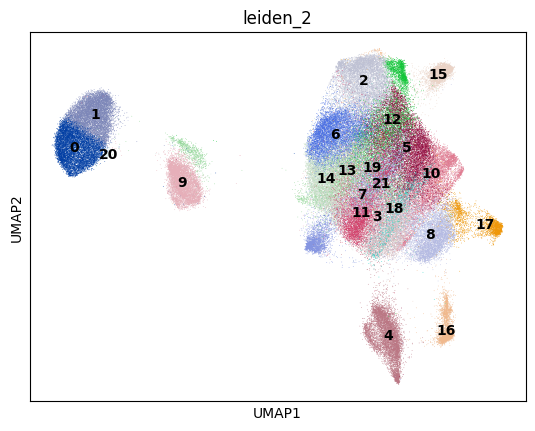

In [30]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

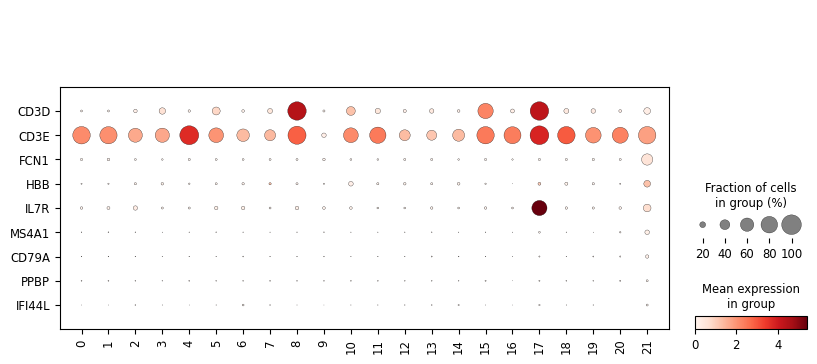

In [31]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

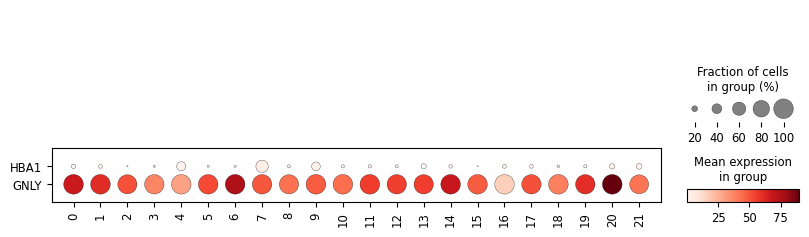

In [32]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['HBA1','GNLY'], swap_axes = True)

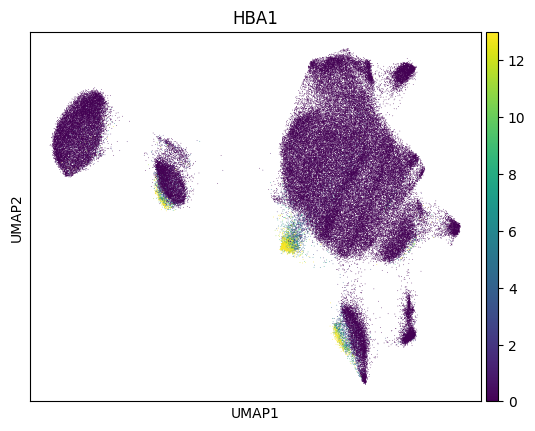

In [33]:
sc.pl.umap(adata, color = 'HBA1', vmax = 'p99')

### IL7R Selection

Removal

In [34]:
adata, n_removed = remove_cl(
    adata, 'IL7R', 'above', 0.4, 'leiden_2'
)
n_removed

['17']


2503

Reason

In [35]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Removal

In [36]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.2, 'leiden_2'
)
n_removed

['21']


21

Reason

In [37]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### HBA1 Selection

Extraction

In [38]:
hba1_adata, n_extracted = extract_cl(
    adata, 'HBA1', 'above', 0.4, 'leiden_2'
)
n_extracted

['7']


6416

Iteratively cluster

In [39]:
hba1_adata = process_adata(hba1_adata, resolution = 2)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


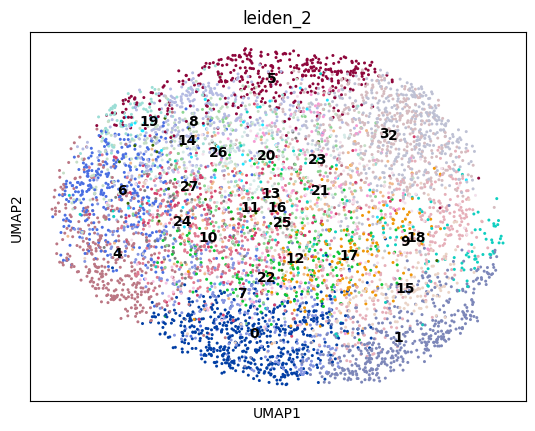

In [40]:
sc.pl.umap(hba1_adata, color = 'leiden_2', legend_loc = 'on data')

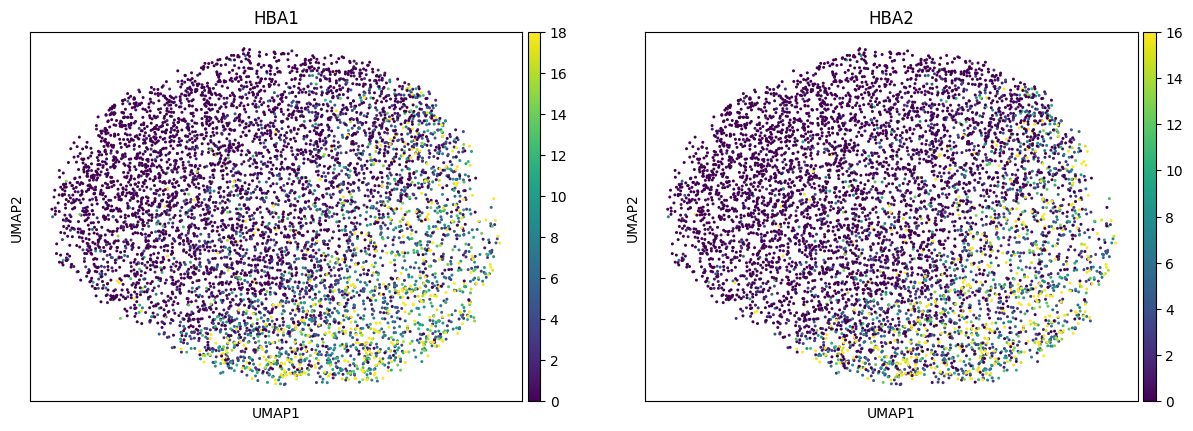

In [41]:
sc.pl.umap(hba1_adata, color = ['HBA1','HBA2'], legend_loc = 'on data', vmax = 'p95')

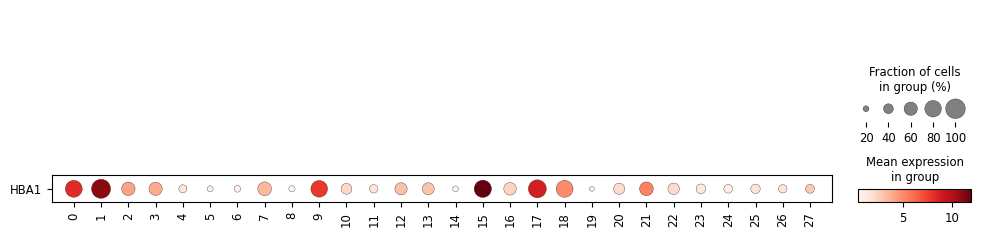

In [42]:
sc.pl.dotplot(hba1_adata, groupby = 'leiden_2', var_names = 'HBA1', swap_axes = True)

In [43]:
hba1_cl = select_clusters_above_gene_frac(
    hba1_adata, 'HBA1', 0.8, clusters = 'leiden_2'
)
hba1_cl

['0', '1', '9', '15', '17', '18']

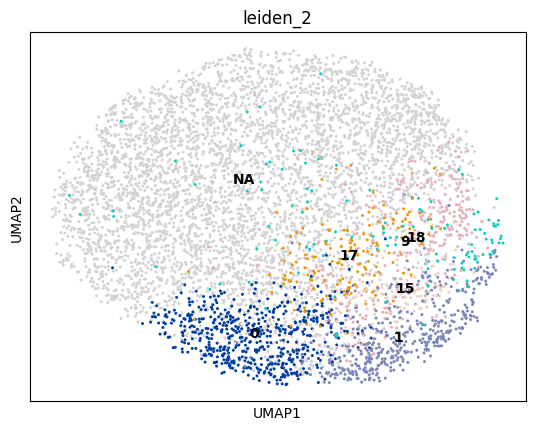

In [44]:
sc.pl.umap(hba1_adata, color = 'leiden_2', legend_loc = 'on data', groups = hba1_cl)

In [45]:
hba1_bc = hba1_adata.obs['barcodes'].loc[hba1_adata.obs['leiden_2'].isin(hba1_cl)]

Remove

In [46]:
hba1_idx = adata.obs['barcodes'].isin(hba1_bc)
keep_idx = [not x for x in hba1_idx]
adata = adata[keep_idx]

Reason

In [47]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [len(hba1_bc)],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [48]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


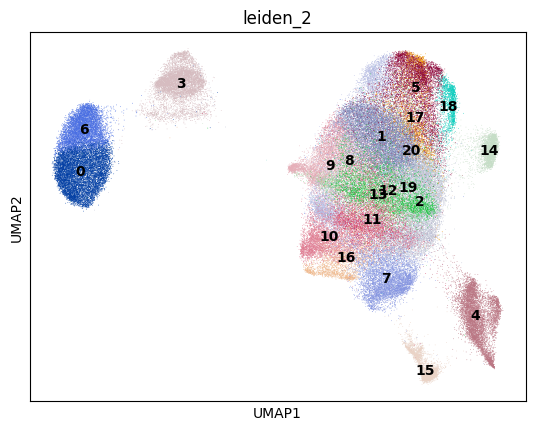

In [49]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [50]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review GZMK+ CD56dim NK cell

### Proposed updates

- Remove CD3D+/IL7R+ cluster as T cell doublet
- Remove HBA1+ cluster as Erythrocyte doublet

In [51]:
cell_type = 'GZMK+ CD56dim NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [52]:
type_uuid

'e865f0db-cc01-4e9b-bce2-36697a892927'

In [53]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [54]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

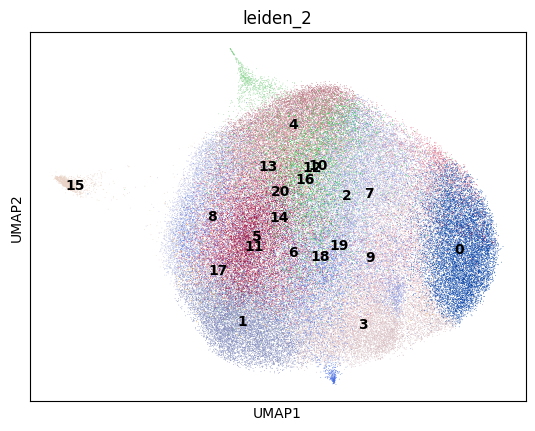

In [55]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

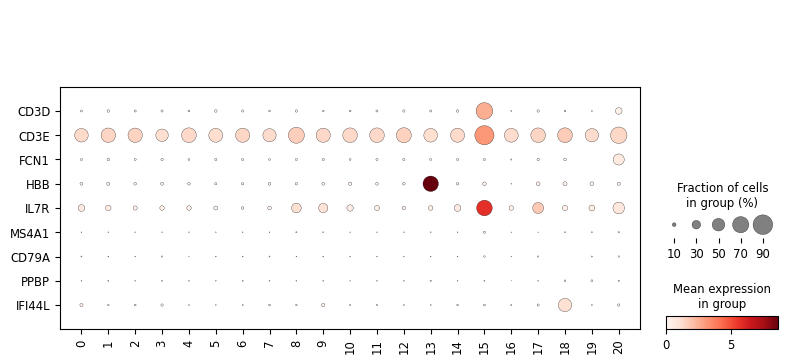

In [56]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### CD3D Selection

Removal

In [57]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.4, 'leiden_2'
)
n_removed

['15']


1542

Reason

In [58]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Removal

In [59]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.2, 'leiden_2'
)
n_removed

['20']


38

Reason

In [60]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### HBB Selection

Remove

In [61]:
hba1_adata, n_removed = remove_cl(
    adata, 'HBB', 'above', 0.4, 'leiden_2'
)
n_removed

['13']


2439

Reason

In [62]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [63]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


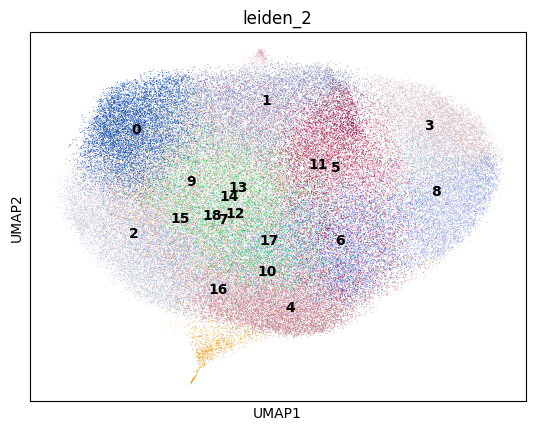

In [64]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [65]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ISG+ CD56dim NK cell

### Suggested updates

- Remove CD3D+/IL7R+ clusters as T cell doublet

In [66]:
cell_type = 'ISG+ CD56dim NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [67]:
type_uuid

'031d7bcb-922b-4088-b9f4-1fc2c2c22464'

In [68]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [69]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

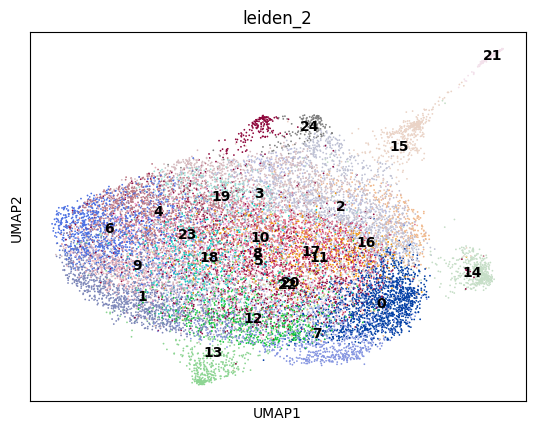

In [70]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

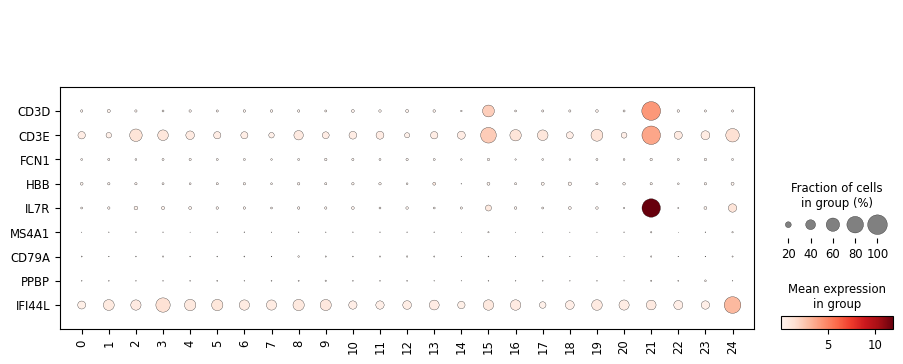

In [71]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### CD3D Selection

Removal

In [72]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.2, 'leiden_2'
)
n_removed

['15', '21']


824

Reason

In [73]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [74]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


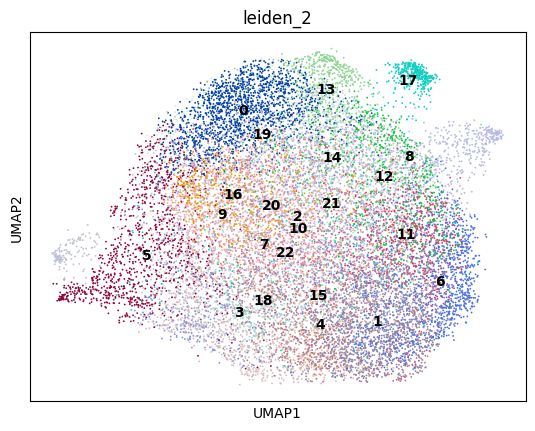

In [75]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [76]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review Proliferating NK cell

### Suggested updates

- Remove CD3D+/IL7R+ cluster (16) as T cell doublet
- Remove FCN1+ cluster (18) as Myeloid doublet

In [77]:
cell_type = 'Proliferating NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [78]:
type_uuid

'cc9f3333-9504-4dde-a8dc-7e41eda58b6b'

In [79]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [80]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

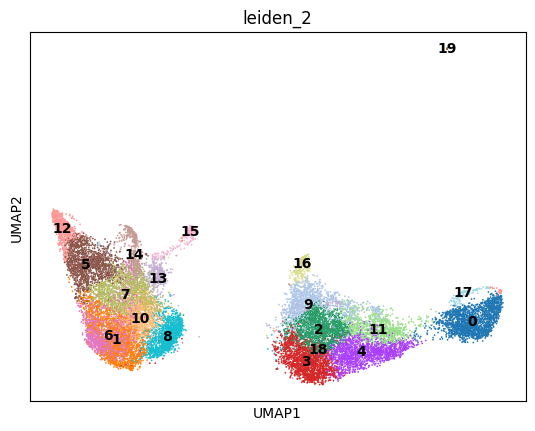

In [81]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

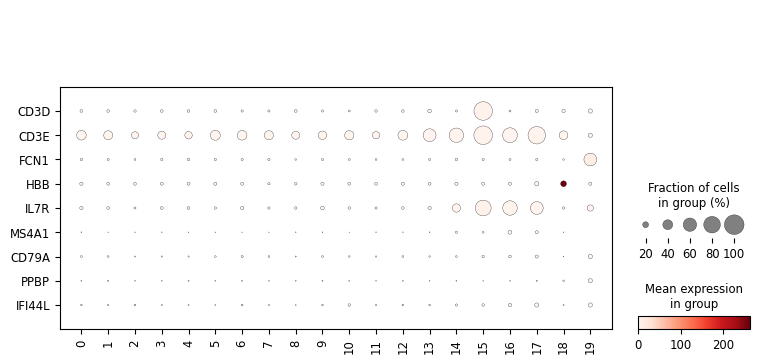

In [82]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

### CD3D Selection

Removal

In [83]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.2, 'leiden_2'
)
n_removed

['15']


323

Reason

In [84]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### FCN1 Selection

Removal

In [85]:
adata, n_removed = remove_cl(
    adata, 'FCN1', 'above', 0.2, 'leiden_2'
)
n_removed

['19']


23

Reason

In [86]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Myeloid doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [87]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


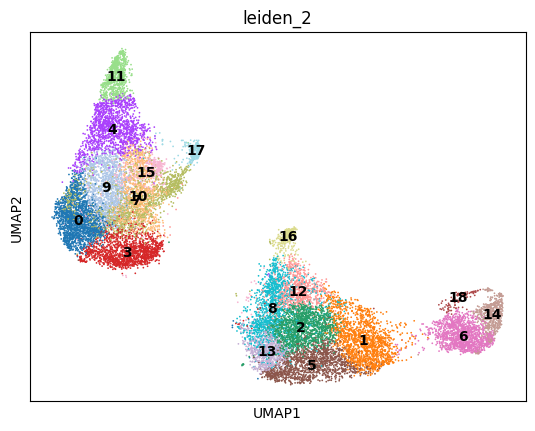

In [88]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [89]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review ILC

### Suggested updates

- Remove CD3D+/IL7R+ cluster (21) as T cell doublet
- Remove GNLY+ cells as mislabeled

In [90]:
cell_type = 'ILC'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [91]:
type_uuid

'07100338-8f65-4ec9-a6f7-aba71c6ace8b'

In [92]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [93]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

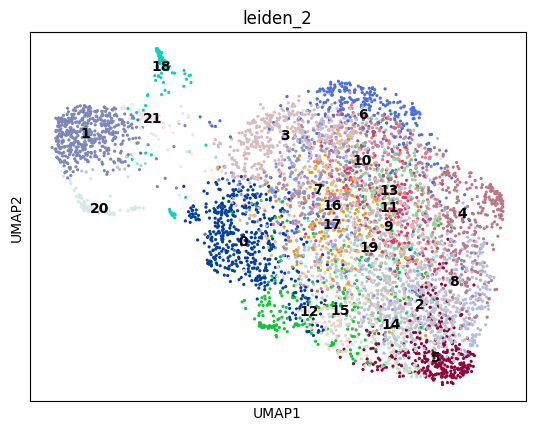

In [94]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

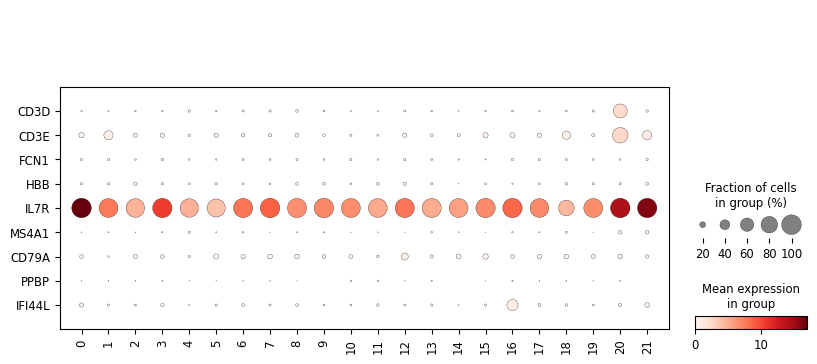

In [95]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

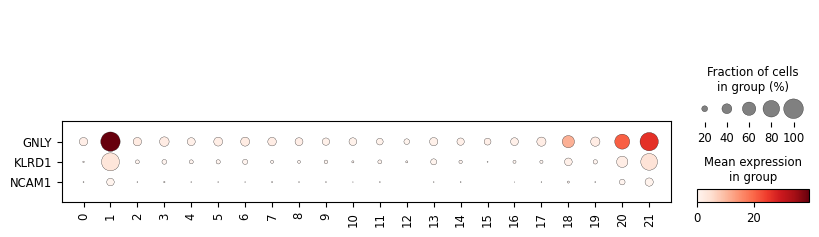

In [96]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['GNLY','KLRD1','NCAM1'], swap_axes = True)

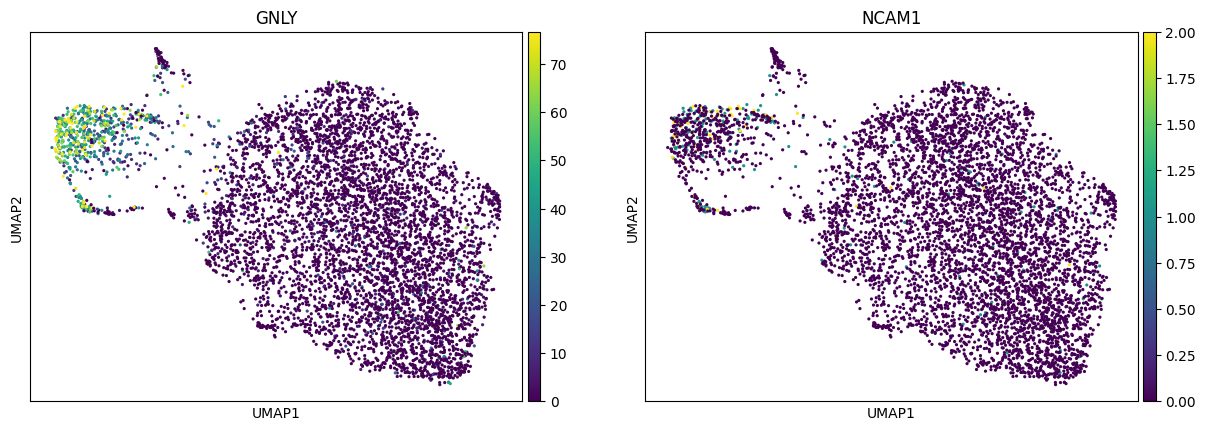

In [97]:
sc.pl.umap(adata, color = ['GNLY','NCAM1'], vmax = 'p99')

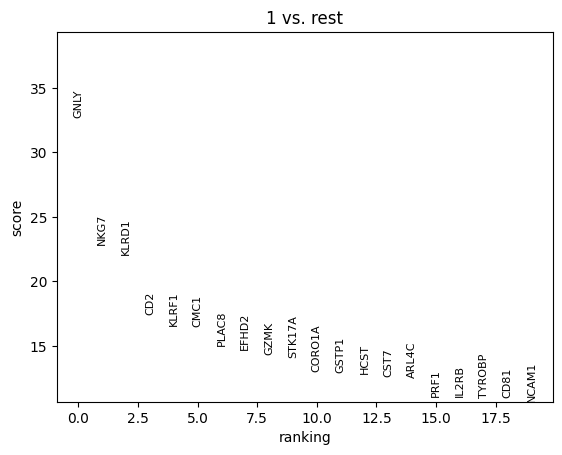

In [98]:
sc.tl.rank_genes_groups(
    adata, groupby = 'leiden_2', groups = ['1']
)
sc.pl.rank_genes_groups(adata)

### CD3D Selection

Removal

In [99]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.2, 'leiden_2'
)
n_removed

['20']


105

Reason

In [100]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### GNLY Removal

Removal

In [101]:
adata, n_removed = remove_cl(
    adata, 'GNLY', 'above', 0.6, 'leiden_2'
)
n_removed

['1', '21']


549

Reason

In [102]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['removed'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Mislabled GNLY+']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [103]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


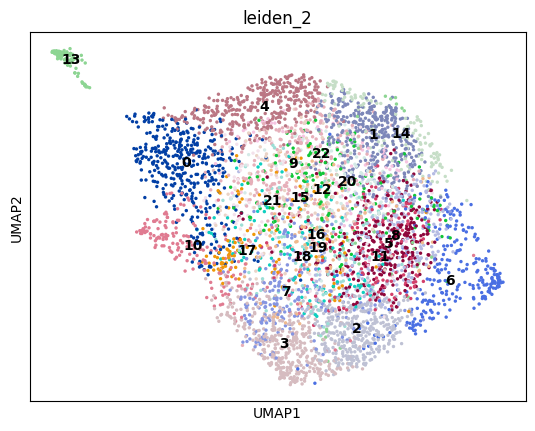

In [104]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [105]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

# Integrate

## Review GZMK- CD56dim NK cell

### Suggested updates

- Remove CD3D+/IL7R+ cluster (13) as T cell doublet
- Remove HBA1+ cluster (10) as Erythrocyte doublet

In [106]:
cell_type = 'GZMK- CD56dim NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [107]:
type_uuid

'32fa4f42-10f8-45ea-9dcc-f610476262bc'

In [108]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [109]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

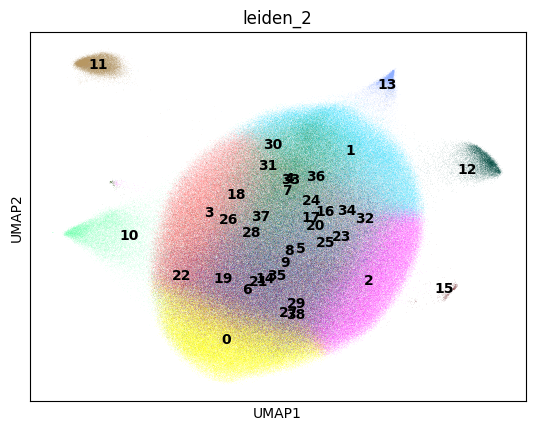

In [110]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

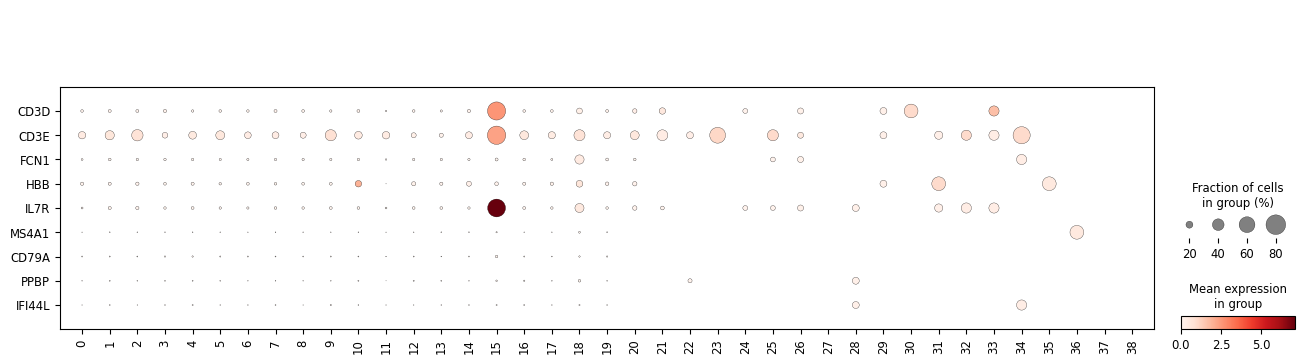

In [111]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

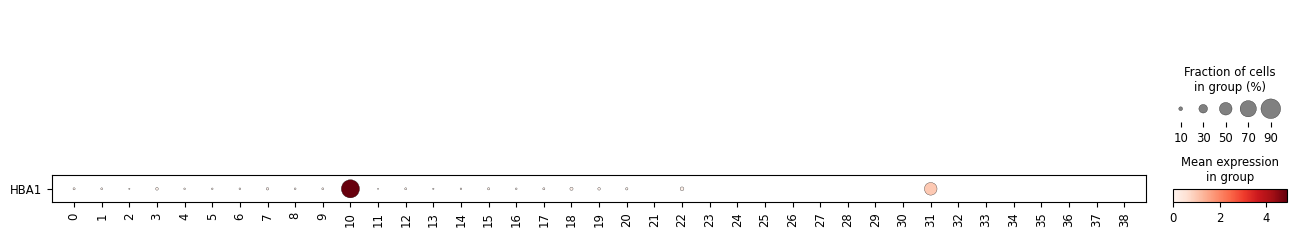

In [112]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['HBA1'], swap_axes = True)

### CD3D Selection

Removal

In [113]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.2, 'leiden_2'
)
n_removed

['15', '30', '33']


896

Reason

In [114]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### HBA1 Selection

Removal

In [115]:
adata, n_removed = remove_cl(
    adata, 'HBA1', 'above', 0.4, 'leiden_2'
)
n_removed

['10', '31']


28560

Reason

In [116]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [117]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


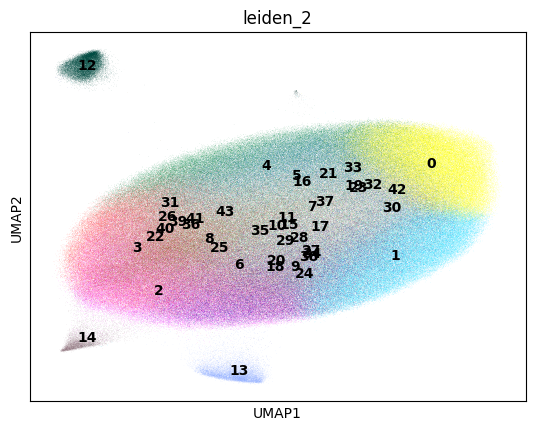

In [118]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Save filtered cells

In [119]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Review CD56bright NK cell

### Suggested updates

- Remove CD3D+/IL7R+ cluster (9) as T cell doublet

In [120]:
cell_type = 'CD56bright NK cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [121]:
type_uuid

'45cefd74-23ad-497c-b374-f8a52a67acd3'

In [122]:
adata = read_adata_uuid(type_uuid)
total_cells = adata.shape[0]

In [123]:
adata.obs['predicted_AIFI_L3'] = adata.obs['AIFI_L3']

### Clustering

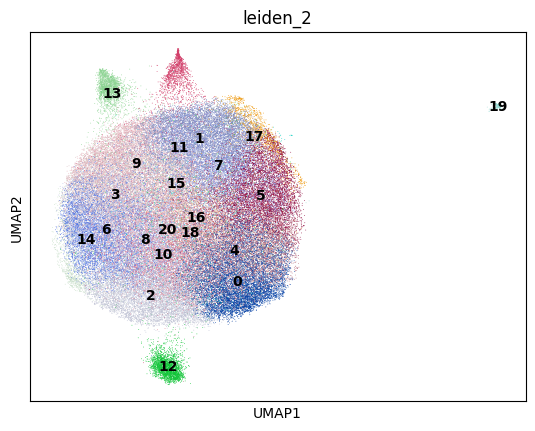

In [124]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

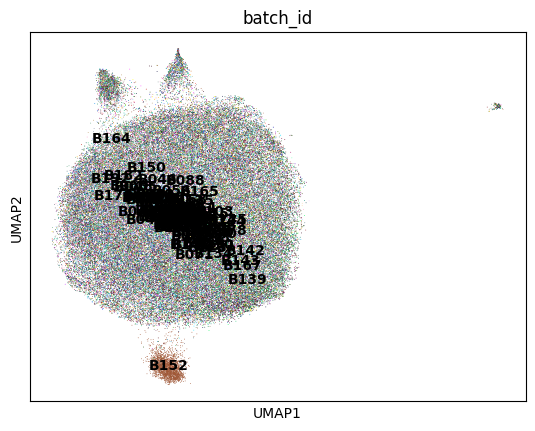

In [125]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

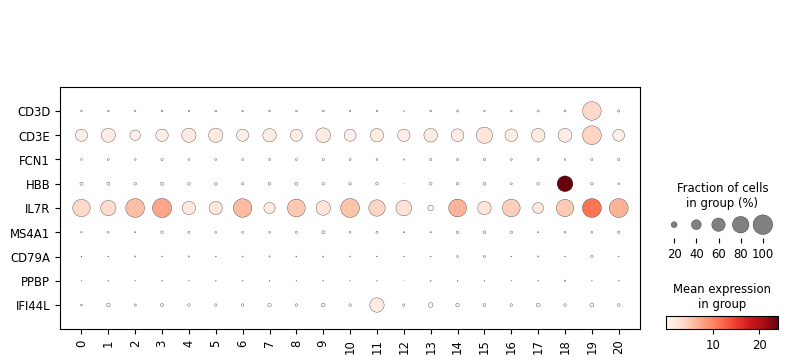

In [126]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

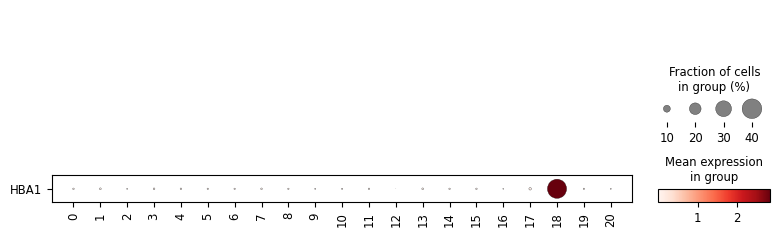

In [127]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['HBA1'], swap_axes = True)

### CD3D Selection

Removal

In [128]:
adata, n_removed = remove_cl(
    adata, 'CD3D', 'above', 0.2, 'leiden_2'
)
n_removed

['19']


484

Reason

In [129]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['T cell doublet']
    }
)
update_list.append(update_df)

### HBA1 Selection

Removal

In [130]:
adata, n_removed = remove_cl(
    adata, 'HBA1', 'above', 0.2, 'leiden_2'
)
n_removed

['18']


837

Reason

In [131]:
update_df = pd.DataFrame(
    {'AIFI_L3': [cell_type],
     'update_type': ['remove'],
     'n_total': [total_cells],
     'n_updated': [n_removed],
     'change_to': ['Erythrocyte doublet']
    }
)
update_list.append(update_df)

### Reprocess filtered cells

In [ ]:
adata = process_adata(adata, resolution = 2)
adata = propagate_hierarchy(adata, hierarchy_df)

In [ ]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

In [ ]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3', legend_loc = 'on data')

### Save filtered cells

In [ ]:
out_type = format_cell_type(cell_type)
out_file = 'output/diha_filtered_celltypist_L3_{ot}_{d}.h5ad'.format(ot = out_type, d = date.today())
adata.write_h5ad(out_file)
out_files.append(out_file)

## Assemble update reasoning

In [ ]:
update_df = pd.concat(update_list)

In [ ]:
update_df

In [ ]:
out_update = 'output/diha_filtered_celltypist_L3_NK_reasons_{d}.csv'.format(d = date.today())
update_df.to_csv(out_update)
out_files.append(out_update)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [ ]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA CellTypist L3 NK Filtered {d}'.format(d = date.today())

In [ ]:
search_id = element_id()
search_id

In [ ]:
in_files = search_df['id'].tolist()
in_files

In [ ]:
out_files

In [ ]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

In [ ]:
import session_info
session_info.show()